*Notebook voor het omzetten van de met Wageningenmodellen en overstortschatter berekende afvoeren naar lateralen D_HYDRO.*

Import the required modules

In [1]:
import os
import pandas as pd
import geopandas as gpd
import re
import matplotlib.pyplot as plt
import xml.etree.ElementTree as et 
import mplleaflet as mpl
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Set relative paths to input data

In [2]:
absolute_path = os.path.abspath('')
laterals_shp_path = os.path.abspath(os.path.join(absolute_path, '..', '03_Data', 'laterals_shapefile', 'laterals.shp'))
overstorten_shp_path = os.path.abspath(os.path.join(absolute_path, '..', '03_Data', 'overstortpunten_shapefile', 'overstortlocaties.shp'))
overstorten_data_path = os.path.abspath(os.path.join(absolute_path, '..', '03_Data', 'overstortschatter_output'))
wagmod_shp_path = os.path.abspath(os.path.join(absolute_path, '..', '03_Data', 'wageningenmodel_shapefile', 'NAvakken.shp'))
wagmod_data_path = os.path.abspath(os.path.join(absolute_path, '..', '03_Data', 'wageningenmodel_output'))
output_data_path = os.path.abspath(os.path.join(absolute_path, '..', '07_Rapportage', 'outputlocations.shp'))

absolute_path
laterals_shp_path
overstorten_shp_path
overstorten_data_path
wagmod_shp_path
wagmod_data_path
output_data_path

'd:\\werkplan 2023\\kennisagenda\\23K01_dhydromodellering\\01-importeer-neerslag-afvoer-uit-modellen\\06_Scripts'

'd:\\werkplan 2023\\kennisagenda\\23K01_dhydromodellering\\01-importeer-neerslag-afvoer-uit-modellen\\03_Data\\laterals_shapefile\\laterals.shp'

'd:\\werkplan 2023\\kennisagenda\\23K01_dhydromodellering\\01-importeer-neerslag-afvoer-uit-modellen\\03_Data\\overstortpunten_shapefile\\overstortlocaties.shp'

'd:\\werkplan 2023\\kennisagenda\\23K01_dhydromodellering\\01-importeer-neerslag-afvoer-uit-modellen\\03_Data\\overstortschatter_output'

'd:\\werkplan 2023\\kennisagenda\\23K01_dhydromodellering\\01-importeer-neerslag-afvoer-uit-modellen\\03_Data\\wageningenmodel_shapefile\\NAvakken.shp'

'd:\\werkplan 2023\\kennisagenda\\23K01_dhydromodellering\\01-importeer-neerslag-afvoer-uit-modellen\\03_Data\\wageningenmodel_output'

'd:\\werkplan 2023\\kennisagenda\\23K01_dhydromodellering\\01-importeer-neerslag-afvoer-uit-modellen\\07_Rapportage\\outputlocations.shp'

Customize some settings that you want

In [3]:
INTEGRITY = False # TODO: Run the script for historic overstort data again with better input data, to get rid of the double indices.
scenarios = [ # Turn on or off the scenarios that must be ran
    'HIST',
    'GHG120'
    ]

Read the shapefiles containing:
- The locations of the laterals to which the must finally be coupled
- The location of the overstorten
- The polygons that are used by the Wageningen Model, to know which discharge to couple with which laterals

In [4]:
gdf_laterals = (
    gpd.read_file(laterals_shp_path)
    .set_index('CODE', verify_integrity = True)
    [['Opp_hactar','X','Y','geometry']]
)
gdf_laterals['type'] = 'laterals'

gdf_wagmod = (
    gpd.read_file(wagmod_shp_path)
    [['GAFIDEN','geometry']]
)

gdf_overstorten = gpd.read_file(overstorten_shp_path).set_index('RIODAT_ZRO', 
    verify_integrity=INTEGRITY 
    )[['geometry']]
gdf_overstorten['type'] = 'overstort'

gdf_laterals.head()
gdf_wagmod.head()
gdf_overstorten.head()


,Opp_hactar,X,Y,geometry,type
CODE,,,,,
2011720L,30.109247,153611.0,411394.0,POINT (153610.957 411394.440),laterals
1087820L,3.054930,179156.0,417650.0,POINT (179156.491 417649.850),laterals
2341490L,13.678861,170792.0,386422.0,POINT (170792.129 386422.037),laterals
1130423L,20.861191,197661.0,398076.0,POINT (197661.249 398076.213),laterals
2613972L,6.890049,177393.0,389692.0,POINT (177393.001 389692.403),laterals


,GAFIDEN,geometry
0,107a,"POLYGON ((181239.885 413496.624, 181356.345 41..."
1,112,"POLYGON ((198494.918 404086.773, 198514.509 40..."
2,112,"POLYGON ((197040.942 402079.256, 196964.548 40..."
3,108a,"POLYGON ((187679.170 408065.972, 188475.450 40..."
4,114a,"POLYGON ((195514.316 404681.126, 195318.198 40..."


,geometry,type
RIODAT_ZRO,,
VEG-EER-BER-64,POINT (162609.027 401348.286),overstort
CUI-CUI-VAL-5,POINT (189058.510 417195.842),overstort
SMI-DEN-SCH-23,POINT (154135.806 408755.925),overstort
HEU-HAA-HEU-40,POINT (141401.809 413356.388),overstort
VEG-VEG-PUN-68,POINT (163881.206 400954.512),overstort


Plot the different shapes to create an idea of what we are dealing with. Notice that not all locations are located within the shapefiles of the Wageningen model.

c:\Users\langjo02\.conda\envs\delft3dfmpy_2.0.3\lib\site-packages\descartes\patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +
c:\Users\langjo02\.conda\envs\delft3dfmpy_2.0.3\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

(170000.0, 210000.0)

(391000.0, 427000.0)

(170000.0, 210000.0)

(391000.0, 427000.0)

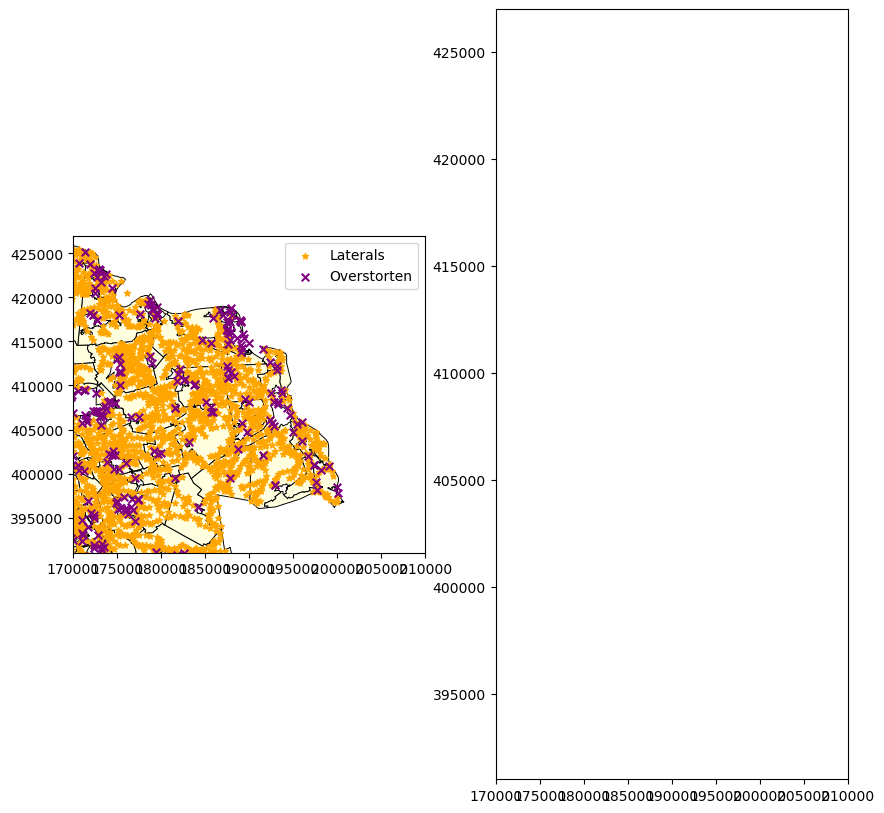

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 10))

gdf_wagmod.plot(ax=ax1, fc="lightyellow", edgecolor='black', lw=0.7)
gdf_laterals.plot(ax=ax1, color = 'orange', marker = '*', markersize = 20, label='Laterals')
gdf_overstorten.plot(ax=ax1, color = 'purple', marker='x',markersize = 30, label='Overstorten')

ax1.set_xlim(170000, 210000)
ax1.set_ylim(391000, 427000)
ax2.set_xlim(170000, 210000)
ax2.set_ylim(391000, 427000)
ax1.legend()
fig

Combine the tables of the laterals and the overstorten and save this shapefile. One output of the script is to create a shapefile with all the locations to which model data must be coupled, which is hereby done.

In [6]:
# Create the shapefile containing all locations (laterals and overstorten). This is a component of the final output.
pd.concat([gdf_laterals,gdf_overstorten], 
    verify_integrity=INTEGRITY 
    )[['geometry','type']].to_file(output_data_path)
    

The attributes of the Wageningen model are joined to the laterals that are located inside the Wageningen model polygons, specifically to obtain the 'GAFIDEN' belonging to that polygon. This 'GAFIDEN' is the identifier that is used by output data of Wageningen model afvoer data. This will be used later on.

,Opp_hactar,X,Y,geometry,type,index_right,GAFIDEN
CODE,,,,,,,
2011720L,30.109247,153611.0,411394.0,POINT (153610.957 411394.440),laterals,41.0,205
1087820L,3.054930,179156.0,417650.0,POINT (179156.491 417649.850),laterals,192.0,108b
2341490L,13.678861,170792.0,386422.0,POINT (170792.129 386422.037),laterals,165.0,234c
1130423L,20.861191,197661.0,398076.0,POINT (197661.249 398076.213),laterals,37.0,113
2613972L,6.890049,177393.0,389692.0,POINT (177393.001 389692.403),laterals,51.0,261a


c:\Users\langjo02\.conda\envs\delft3dfmpy_2.0.3\lib\site-packages\descartes\patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +
c:\Users\langjo02\.conda\envs\delft3dfmpy_2.0.3\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


<AxesSubplot:>

<AxesSubplot:>

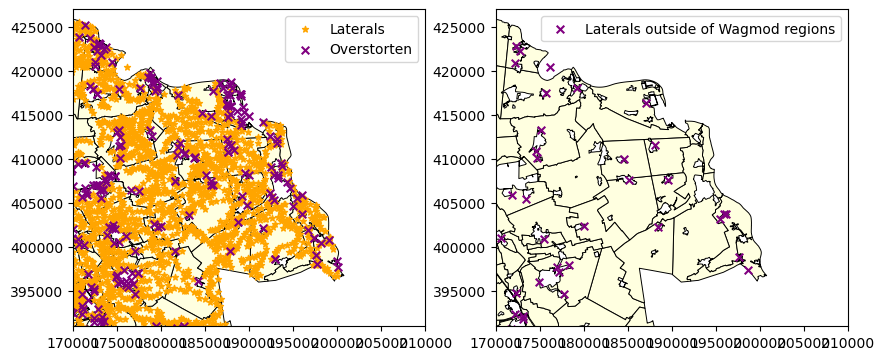

In [7]:
gdf_laterals_joined = gpd.sjoin(gdf_laterals, gdf_wagmod, how='left')
gdf_laterals_joined.head()

gdf_wagmod.plot(ax=ax2, fc="lightyellow", edgecolor='black', lw=0.7)
gdf_missing = gdf_laterals_joined.loc[gdf_laterals_joined['index_right'].isna()]
gdf_missing.plot(ax=ax2, color = 'purple', marker='x',markersize = 30, label = 'Laterals outside of Wagmod regions')
ax2.legend()
fig
#TODO: locaties die niet binnen een Wagmod gebied vallen moeten op e.o.a. manier gekoppeld worden aan Wagmod data. 
# Mijn voorkeur zou zijn een koppeltabel voor die 100 locaties.
#TODO: checken hoe het nu precies zit met de lateralen van wageningen model en de overstorten in dat lateralen bestand. 

Per scenario: 
1) list the files inside the relevant folder
2) Create an empty list that will later contain the Wageningen Model data for this scenario for all regions
3) Per Region:
    - Read metadata from the top of the file to extract the model number
    - Read the actual data 
    - Convert the numeral time steps into a datetime
    - Add the data to the list that was made in step 2
4) Combine all the dataframes in the list into one dataframe

In [8]:
for scenario in scenarios:
    
    ## Read Wageningen model output (discharges) per region, and multiply by the area belonging to each lateral
    wagmodFiles = [wagmod_data_path + '//' + scenario+ '/' + region for region in os.listdir(wagmod_data_path + '//' + scenario)]
    ls_wagmodoutput = []
    
    for region in wagmodFiles:
        metadata_region = pd.read_csv(region, nrows=1, skiprows=[0,2], header=None)[0][0]
        model = re.search('model:(.*) (?:van|met winterbui)', metadata_region).group(1)
                
        df_region = pd.read_csv(
                region, 
                header=4, 
                delim_whitespace=True, 
                usecols=['-I-','-QC-'],
                )

        df_region=df_region.set_index(
                pd.to_datetime(df_region['-I-'],
                origin=pd.Timestamp('2010-11-08 23:00:00'),
                unit='h')
            ).drop(labels=['-I-'], axis='columns').rename(columns={'-QC-':model})
        
        ls_wagmodoutput.append(df_region)

    # The result is a list containing dataframes as items
    ls_wagmodoutput, len(ls_wagmodoutput)

    # Combine the dataframes into one big dataframe
    df_wagmodoutput = pd.concat(ls_wagmodoutput, axis=1, verify_integrity=True).T * 10 / 3600
    
    # Set the index to be only the 'GAFIDEN'
    for i in range(len(df_wagmodoutput.index)):
        ID =df_wagmodoutput.index[i].split(' ')[0]
        df_wagmodoutput.loc[df_wagmodoutput.index[i],'GAFIDEN'] = ID

    ### Multiplication
    gdf_laterals_joined['Latid'] = gdf_laterals_joined.index
    #gdf_laterals_joined.set_index('Latid')
    #output_laterals = gdf_laterals_joined.reset_index().merge(df_wagmodoutput, on='GAFIDEN', how='left').set_index(gdf_laterals_joined.index.names)
    #output_laterals = gdf_laterals_joined.join(df_wagmodoutput, on='GAFIDEN', how='left',lsuffix='left',rsuffix='right')
    output_laterals = gdf_laterals_joined.merge(df_wagmodoutput, on='GAFIDEN', how='left')
    #output_laterals = gdf_laterals_joined.merge(df_wagmodoutput, on='GAFIDEN', how='left',lsuffix='left',rsuffix='right')
    #output_laterals.set_index('Latid')
    output_laterals.set_index('Latid', inplace=True)
    output_laterals2 = output_laterals.iloc[:,8:].multiply(output_laterals['Opp_hactar'],axis='index').T

([                         105
  -I-                         
  2010-11-09 00:00:00  0.02494
  2010-11-09 01:00:00  0.02489
  2010-11-09 02:00:00  0.02485
  2010-11-09 03:00:00  0.02481
  2010-11-09 04:00:00  0.02477
  ...                      ...
  2023-11-08 19:00:00  0.00000
  2023-11-08 20:00:00  0.00000
  2023-11-08 21:00:00  0.00000
  2023-11-08 22:00:00  0.00000
  2023-11-08 23:00:00 -0.05224
  
  [113952 rows x 1 columns],
                           106
  -I-                         
  2010-11-09 00:00:00  0.02099
  2010-11-09 01:00:00  0.02098
  2010-11-09 02:00:00  0.02097
  2010-11-09 03:00:00  0.02096
  2010-11-09 04:00:00  0.02095
  ...                      ...
  2023-11-08 19:00:00  0.00196
  2023-11-08 20:00:00  0.00247
  2023-11-08 21:00:00  0.00295
  2023-11-08 22:00:00  0.00340
  2023-11-08 23:00:00  0.00383
  
  [113952 rows x 1 columns],
                          107a
  -I-                         
  2010-11-09 00:00:00  0.02911
  2010-11-09 01:00:00  0.02919
  2010

([                     105 met winterbui:120mm in 3 dagen
  -I-                                                    
  2010-11-09 00:00:00                             0.02478
  2010-11-09 01:00:00                             0.02461
  2010-11-09 02:00:00                             0.02446
  2010-11-09 03:00:00                             0.02433
  2010-11-09 04:00:00                             0.02422
  ...                                                 ...
  2010-11-25 18:00:00                             0.04344
  2010-11-25 19:00:00                             0.04337
  2010-11-25 20:00:00                             0.04329
  2010-11-25 21:00:00                             0.04322
  2010-11-25 22:00:00                             0.04314
  
  [407 rows x 1 columns],
                       106 met winterbui:120mm in 3 dagen
  -I-                                                    
  2010-11-09 00:00:00                             0.02069
  2010-11-09 01:00:00                      

Read the overstort schatter output (xml files)

In [9]:
    ## Delft uses this url to precede the series. I abbreviated this into NS (namespace), to avoid unnecesary clutter in the script.
    NS = '{http://www.wldelft.nl/fews/PI}' # xml default namespace

    #overstortFiles = os.listdir(absolute_path + '/overstortschatter_output/')
    overstortFiles = [overstorten_data_path + '/' + scenario+ '/' + region for region in os.listdir(overstorten_data_path + '/' + scenario)]
    ls_multipleyears = []

    for overstort in overstortFiles:
        xtree = et.parse(overstort)
        xroot = xtree.getroot()
        ls_overstort = []

    overstortFiles
    xroot

['d:\\werkplan 2023\\kennisagenda\\23K01_dhydromodellering\\01-importeer-neerslag-afvoer-uit-modellen\\03_Data\\overstortschatter_output/GHG120/overstortschatter_2010.xml']

<Element '{http://www.wldelft.nl/fews/PI}TimeSeries' at 0x0000025ACDE74EA0>

In [10]:
    for i in xroot.iter(NS+'series'):
        locId = i.find('./'+NS+'header/'+NS+'locationId').text
        events = i.findall('./'+NS+'event')
        ls=[item.attrib for item in events]
        df=pd.DataFrame(ls).head()
    
        df_resetIndex=(
            df.set_index(
            pd.DatetimeIndex(pd.to_datetime(df['date']+' '+df['time'], format="%Y-%m-%d %H:%M:%S")),
            verify_integrity=True
            ).drop(labels=['date','time'], axis='columns')
            .astype('float')
            .rename({'value':locId}, axis='columns')
        )
        ls_overstort.append(df_resetIndex)
    pd_oneyear=pd.concat(ls_overstort, axis='columns',verify_integrity=True)
    ls_multipleyears.append(pd_oneyear)
df_overstorten = pd.concat(ls_multipleyears, axis='index', verify_integrity=True) / 3600

df_combined = pd.concat([output_laterals2,df_overstorten], axis='columns').fillna(value=0)
df_combined.to_csv(os.path.abspath(os.path.join(absolute_path, '../07_Rapportage/'+'afvoer_' + scenario +'.csv')), sep = ';')

## RWZI output # Left out for now, because there are no relevant RWZIs in the pilot area


# Format output